General instructions:
1. Use shift+enter to run cells.
2. The objective of this notebook is to observe the behaviors (calibration and recall) of different fine-mapping methods and how it changes when the ground truths change.

# Load packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.proportion as proportion
from scipy import stats, linalg
import pandas as pd
from susieinf import susie
import warnings
warnings.filterwarnings('ignore')

In [2]:
import rpy2
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
from rpy2.robjects import conversion, default_converter
with conversion.localconverter(default_converter):
    packnames = ('susieR')
    # Load packages
    susieR = importr('susieR', suppress_messages=True)

R[write to console]: Installing packages into ‘/home/ran/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



In [3]:
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri
numpy2ri.activate()
from rpy2.robjects import default_converter
np_cv_rules = default_converter + numpy2ri.converter
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR) 

# Simple simulation, single iteration

## Generate genotype matrix X

This part of the code generates a genotype matrix X.\
The default properties are:
1. Number of SNPs in X is 100. 
2. Pair-wise LD is 0.3
3. The number of individuals is 1000

Later in the exercise you will be asked to change some of these properties.

In [4]:
p = 100 # number of variants in the locus
LD = np.eye(p) # initialize the LD matrix
LD[LD==0] = 0.3 # set all pairwise LD
N = 1000 # number of individuals

In [5]:
X_mean = np.zeros(p) # set the mean genotypes to be zero for each SNP, we assume X is standardized.
X = np.random.multivariate_normal(X_mean, LD, size = N) # generate X according to the preset LD.

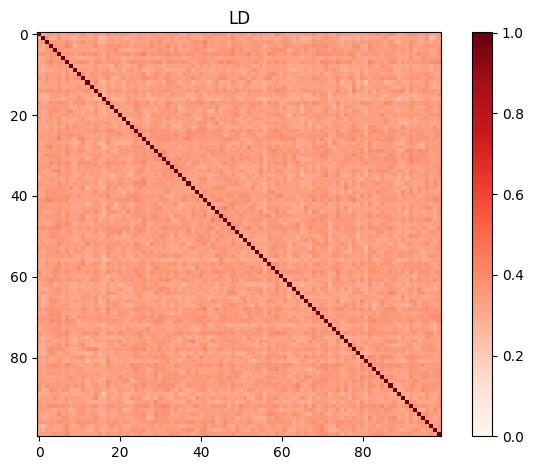

In [6]:
# visualize in-sample LD
X_std = (X-np.mean(X,axis=0))/np.std(X, axis=0)
in_sample_LD = np.cov(X_std.T)
fig, ax = plt.subplots()
im = ax.imshow(in_sample_LD, cmap='Reds', vmin = 0)
ax.set_title("LD")
fig.tight_layout()
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

## Draw effect sizes and simulation phenotype y

This part of the code generate effect sizes of the SNPs in this locus, based on the effect sizes, phenotypes aregenerated.\
The default settings here are:
1. There is 1 causal SNP in this locus
2. The heritability in this region is 0.5
3. There are no infinitesimal effects, meaning that only the causal variant has non-zero effect size

Later in the exercise you will be asked to change some of these properties.

In [7]:
L = 1 # number of causal variants
h2g = 0.5 # set region heritability
inf = False
inf_var = 5e-4

In [8]:
causal_config = np.zeros(p) # initialize causal configuration
causal_ind = np.random.choice(np.arange(p), L, replace=False) # randomly choose L variants to be causal.
print(f"causal variant index: {causal_ind}")
causal_config[causal_ind] = 1 # update the cuasal configuration
per_snp_h2g = h2g/L # get per-SNP heritability
causal_mean = 0 # mean effect size
sigma_squared=0
while sigma_squared<=0.5 or sigma_squared>0.95:
    effect_sizes = np.random.normal(loc = causal_mean, scale = np.sqrt(per_snp_h2g), size = L) # draw effect sizes
    beta = causal_config.copy() # initialize beta
    if inf:
        beta = np.random.normal(loc = 0, scale = np.sqrt(inf_var), size = p)
    beta[causal_ind] = effect_sizes # assign beta based on effect sizes
    genetic_effect = X.dot(beta) # compute genetic effect X\beta
    sigma_squared = 1 - np.var(genetic_effect) # compute error variance assuming total phenotypic variance is 1
print(f"effect_sizes={effect_sizes}")
print(f"sigma_squared={sigma_squared}")
epsilon = np.random.normal(loc = 0, scale = np.sqrt(sigma_squared), size = N) # draw error
y = X.dot(beta) + epsilon # compute phenotype vector

causal variant index: [33]
effect_sizes=[-0.32090621]
sigma_squared=0.8920723007638944


## Run GWAS and visualize the result

This part of the code runs GWAS analysis on the simulated genotype and phenotype data. The objective is to observe the significance level of the causal SNP as well as the non-causal SNPs.

In [9]:
GWAS_results = []
for i in range(p):
    X_i = X[:, i]
    mod = sm.OLS(y,X_i)
    res = mod.fit()
    coef = res.params[0]
    sd = res.bse[0]
    z = coef/sd
    chisq = z**2
    p_val = stats.chi2.sf(chisq, 1, loc=0, scale=1)
    minus_logp = -np.log10(p_val)
    GWAS_results.append([coef, sd, z, chisq, p_val, minus_logp])
GWAS_df = pd.DataFrame(columns = ['beta_marginal', 'se_marginal', 'z', 'chisq', 'p_val', '-log10p'],
                       data = GWAS_results)

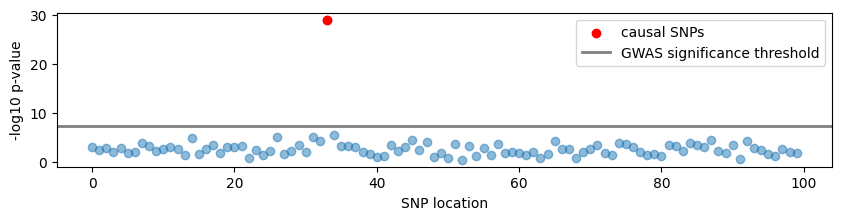

In [10]:
fig,ax = plt.subplots(figsize=(10,2))
plt.scatter(GWAS_df.index, GWAS_df['-log10p'], alpha=0.5)
plt.scatter(causal_ind, GWAS_df.loc[causal_ind, '-log10p'], color = 'red', label = 'causal SNPs')
plt.axhline(y=-np.log10(5e-8), color='grey', linestyle='-', linewidth=2, label = 'GWAS significance threshold')
plt.legend(loc = "best")
plt.xlabel('SNP location')
plt.ylabel('-log10 p-value')
plt.show()

<span style="color:red"> TODO #1</span>: Change the number of individuals (or sample size) N from 1000 to 2000 and observe the GWAS -log10 p-values change.\
<span style="color:red"> TODO #2</span>: Change the LD from 0.3 to 0.9 and observe the change in GWAS -log10 p-values.

## Fine-mapping

This part of the code runs several fine-mapping methods:
1. Approximate Bayes Factor (ABF): assumes single causal variant per locus, PIPs are essentially a monotonic transformation from z-scores.
2. Sum of Single Effects (SuSiE): assumes multiple causal variant per locus.
3. SuSiE-inf: assumes multiple larger effects while accounting for many smaller effects (infinitesimal effects) in the locus.

### ABF

In [11]:
# Define ABF function
def run_abf(beta, stderr, W=0.04):
    # beta and stderr are arrays
    z = beta/stderr
    V = stderr**2
    r = W/(W+V)
    lbf = (np.log(1-r)+(r*(z**2)))/2
    lbf_max = np.max(lbf)
    denom = lbf_max + np.log(np.exp((lbf - lbf_max)).sum())
    prob = np.exp(lbf - denom)
    return lbf, prob

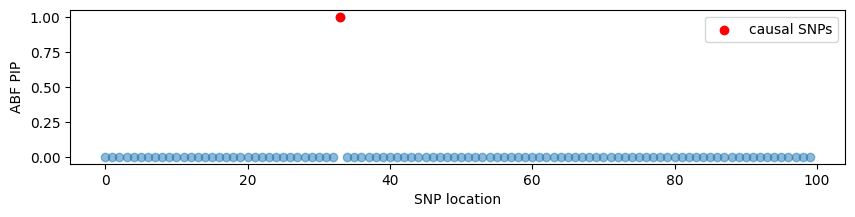

In [12]:
abf_df = GWAS_df.copy()
abf_df['lbf_abf'],abf_df['prob_abf'] = run_abf(GWAS_df['beta_marginal'],GWAS_df['se_marginal'])
fig,ax = plt.subplots(figsize=(10,2))
plt.scatter(abf_df.index, abf_df['prob_abf'], alpha=0.5)
plt.scatter(causal_ind, abf_df.loc[causal_ind, 'prob_abf'], color = 'red', label = 'causal SNPs')
plt.legend(loc = "best")
plt.xlabel('SNP location')
plt.ylabel('ABF PIP')
plt.show()

### SuSiE

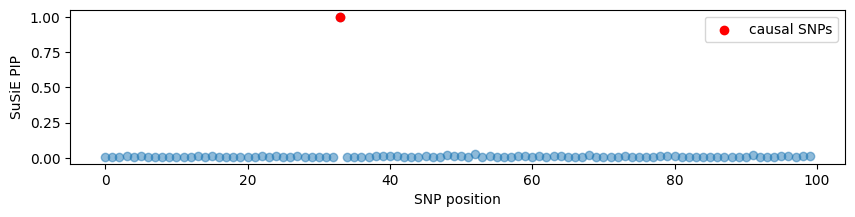

In [13]:
beta_rvec = rpy2.rinterface.FloatSexpVector(GWAS_df['beta_marginal'].values)
se_rvec = rpy2.rinterface.FloatSexpVector(GWAS_df['se_marginal'].values)
var_y = np.var(y)
nr,nc = LD.shape
LD_rvec = ro.r.matrix(in_sample_LD, nrow=nr, ncol=nc)

allowed_causal = L+1
with localconverter(ro.default_converter + np_cv_rules) as cv:
    susie_results = susieR.susie_rss(bhat = beta_rvec, 
                                     shat = se_rvec, n = N, R = LD_rvec,
          var_y = var_y, L = allowed_causal, estimate_residual_variance = True)
susie_df = GWAS_df.copy()
susie_df['prob_susie'] = susie_results['pip']

fig,ax = plt.subplots(figsize=(10,2))
plt.scatter(susie_df.index, susie_df['prob_susie'], alpha=0.5)
plt.scatter(causal_ind, susie_df.loc[causal_ind, 'prob_susie'], color = 'red', label = 'causal SNPs')
plt.legend(loc = "best")
plt.xlabel('SNP position')
plt.ylabel('SuSiE PIP')
plt.show()

### SuSiE-inf

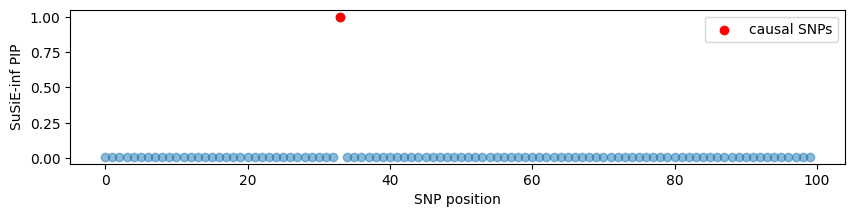

In [14]:
eigenvals,V = linalg.eigh(in_sample_LD)
Dsq = N * eigenvals
susieinf_results = susie(GWAS_df['z'], var_y, 
                      N, allowed_causal, V=V, Dsq=Dsq, method='MLE',
                      tausq_range=(1e-12,1.2),
                      est_tausq=True, est_sigmasq=True, verbose=False)
susieinf_df = GWAS_df.copy()
susieinf_df['prob_susieinf'] = 1 - (1-susieinf_results['PIP']).prod(axis=1)

fig,ax = plt.subplots(figsize=(10,2))
plt.scatter(susieinf_df.index, susieinf_df['prob_susieinf'], alpha=0.5)
plt.scatter(causal_ind, susieinf_df.loc[causal_ind, 'prob_susieinf'], color = 'red', label = 'causal SNPs')
plt.legend(loc = "best")
plt.xlabel('SNP position')
plt.ylabel('SuSiE-inf PIP')
plt.show()

<span style="color:red"> TODO #3</span>: Change the L value at the beginning of the "Draw effect sizes and simulation phenotype y" section to 3, and h2g to 0.5. Reset the pairwise LD to 0.3, LD is defined before generating X. Run through the fine-mapping section and observe the results from different fine-mapping methods.\
<span style="color:red"> TODO #4</span>: Change the inf option to True. Run through the fine-mapping section and observe the results from different fine-mapping methods.

# Aggregate multiple simulations

We have done single iteration simulations. Due to randomness, it's hard to gauge the performance of these methods if we only have results from a single simulation. In this section, we perform multiple iterations (in this case 100) and aggregate the results, therefore quantify the calibration and recall of the methods.

## Define functions

In [15]:
def sim_geno(p, LD, N):
    X_mean = np.zeros(p) # set the mean genotypes to be zero for each SNP, we assume X is standardized.
    X = np.random.multivariate_normal(X_mean, LD, size = N) # generate X according to the preset LD.
    return X

def run_abf(beta, stderr, W=0.04):
    # beta and stderr are arrays
    z = beta/stderr
    V = stderr**2
    r = W/(W+V)
    lbf = (np.log(1-r)+(r*(z**2)))/2
    lbf_max = np.max(lbf)
    denom = lbf_max + np.log(np.exp((lbf - lbf_max)).sum())
    prob = np.exp(lbf - denom)
    return lbf, prob

def run_susie(beta_marginal, se_marginal, LD=None, N=1, var_y=1.0, allowed_causal=10):
    beta_rvec = rpy2.rinterface.FloatSexpVector(beta_marginal)
    se_rvec = rpy2.rinterface.FloatSexpVector(se_marginal)
    nr,nc = LD.shape
    LD_rvec = ro.r.matrix(LD, nrow=nr, ncol=nc)
    with localconverter(ro.default_converter + np_cv_rules) as cv:
        susie_results = susieR.susie_rss(bhat = beta_rvec, 
                                         shat = se_rvec, n = N, R = LD_rvec,
              var_y = 1.0, L = allowed_causal, estimate_residual_variance = True)
    return susie_results['pip']

def run_susieinf(z, LD=None, V=None, Dsq=None, N=1, var_y=1.0, allowed_causal=10, fit_inf=True):
    susieinf_results = susie(z, var_y, 
                      N, allowed_causal, 
                      LD=LD, V=V, Dsq=Dsq, method='MLE',
                      tausq_range=(1e-12,1.2),
                      est_tausq=fit_inf, est_sigmasq=True, verbose=False)
    return 1 - (1-susieinf_results['PIP']).prod(axis=1)

def simulate_phenos(p=10, L=1, h2g=0.3, inf=False, inf_var=5e-4):
    causal_config = np.zeros(p) 
    causal_ind = np.random.choice(np.arange(p), L, replace=False)
    causal_config[causal_ind] = 1
    h2g = h2g
    per_snp_h2g = h2g/L
    causal_mean = 0
    sigma_squared=0
    while sigma_squared<=0:
        effect_sizes = np.random.normal(loc = causal_mean, 
                                        scale = np.sqrt(per_snp_h2g), size = L)
        beta = causal_config.copy()
        if inf:
            beta = np.random.normal(loc=0, scale=np.sqrt(inf_var), size=p)
        beta[causal_ind] = effect_sizes
        genetic_effect = X.dot(beta)
        sigma_squared = 1 - np.var(genetic_effect)
    epsilon = np.random.normal(loc = 0, scale = np.sqrt(sigma_squared), size = N)
    y = X.dot(beta) + epsilon
    return causal_config, beta, y

def ols_gwas(y, X):
    GWAS_results = []
    p = X.shape[1]
    for i in range(p):
        X_i = X[:, i]
        mod = sm.OLS(y,X_i)
        res = mod.fit()
        coef = res.params[0]
        sd = res.bse[0]
        z = coef/sd
        chisq = z**2
        p_val = stats.chi2.sf(chisq, 1, loc=0, scale=1)
        minus_logp = -np.log10(p_val)
        GWAS_results.append([coef, sd, z, chisq, p_val, minus_logp])
    GWAS_df = pd.DataFrame(columns = ['beta_marginal', 'se_marginal', 'z', 'chisq', 'p_val', '-log10p'],
                           data = GWAS_results)
    return GWAS_df

## Perform simulations

In [16]:
p=100 # number of variants in the locus
LD = np.eye(p) # initialize the LD matrix
LD[LD==0] = 0.3 # set all pairwise LD
N = 1000 # number of individuals
X = sim_geno(p, LD, N)
X_std = (X-np.mean(X,axis=0))/np.std(X, axis=0)
in_sample_LD = np.cov(X_std.T)

num_iter = 100 # set the number of iterations in our simulation
L=1
h2g=0.3
allowed_causal=L+1
sim_inf = False

In [17]:
sims_list = []
for i in range(num_iter):
    # simulate ground truths
    config, beta, y = simulate_phenos(p=p, L=L, h2g=h2g, inf=sim_inf)
    # run GWAS
    sim_df = ols_gwas(y, X)
    # run ABF
    _, sim_df['abf_prob'] = run_abf(sim_df['beta_marginal'], sim_df['se_marginal'])
    # run SuSiE
    sim_df['susie_prob'] = run_susie(sim_df['beta_marginal'], sim_df['se_marginal'], 
                                     LD=in_sample_LD, N=X.shape[0], var_y=np.var(y), allowed_causal=allowed_causal)

    eigenvals,V = linalg.eigh(in_sample_LD)
    Dsq = N * eigenvals
    sim_df['susieinf_prob'] = run_susieinf(sim_df['z'], V=V, Dsq=Dsq, N=X.shape[0], var_y=np.var(y), 
                                     allowed_causal=allowed_causal, fit_inf=True)
    sim_df['beta_true'] = beta
    sim_df['causal_config'] = config
    sim_df['pheno'] = i
    sims_list.append(sim_df)
all_sims = pd.concat(sims_list, axis=0)
all_sims['v'] = [f"{a[0]}_{a[1]}" for a in zip(all_sims['pheno'], all_sims.index)]

## Visualize calibration and recall

### Version 1 -- binning

In [18]:
methods = ['abf','susie','susieinf']
bins = [0, 0.01, 0.1, 0.5, 0.9, 1] # PIP bins
bin_labels = [f"({bins[i]},{bins[i+1]}]" for i in range(len(bins)-1)] # bin labels
calib_dict = dict()
# get calibration for all three methods
for method in methods:
    all_sims[f"{method}_prob_label"] = pd.cut(all_sims[f"{method}_prob"], 
                                              bins=bins, labels=bin_labels, include_lowest=True) #assign PIPs to bins
    calib_df = all_sims.groupby(f"{method}_prob_label", observed=False)['v'].count().to_frame().reset_index() # count the number of SNPs in each bin
    calib_df.columns = ['prob_group', 'tot_v']
    calib_df['num_causal'] = all_sims.groupby(f"{method}_prob_label", observed=False)['causal_config'].apply(np.count_nonzero).values # count the number of true causal SNPs in each bin, a SNP is true causal if causal_config!=0
    calib_df['mean_pip'] = all_sims.groupby(f"{method}_prob_label", observed=False)[f"{method}_prob"].mean().values # compute the mean(PIP) in each bin
    calib_df['prop_causal'] = calib_df['num_causal']/calib_df['tot_v']
    # compute confidence interval
    calib_df['lower'], calib_df['upper'] = proportion.proportion_confint(calib_df['num_causal'], calib_df['tot_v'], 
                                             method='binom_test', alpha=0.05)
    calib_dict[method] = calib_df
# get recall for all three methods
tot_causal = all_sims[all_sims['causal_config']!=0].shape[0]
perc = [0.1, 1, 5, 10, 25] # top a percent of total SNPs
tot_snps = all_sims.shape[0]
top_n = [int(a*tot_snps/100) for a in perc]
recall_dict = dict()
for method in methods:
    recall_df = pd.DataFrame(columns=['perc', 'top_n', 'tot_causal', 'num_causal'], 
                             index=[x for x in range(len(perc))])
    recall_df[['perc','top_n','tot_causal']] = np.array([perc, top_n, [tot_causal]*len(perc)]).T
    recall_df['num_causal'] = [all_sims.nlargest(n, f'{method}_prob')['causal_config'].apply(lambda x: (x!=0)).sum() for n in top_n]
    recall_df['recall'] = recall_df['num_causal']/recall_df['tot_causal']
    recall_df['lower'], recall_df['upper'] = proportion.proportion_confint(recall_df['num_causal'], recall_df['tot_causal'], 
                                             method='binom_test', alpha=0.05)
    recall_dict[method] = recall_df

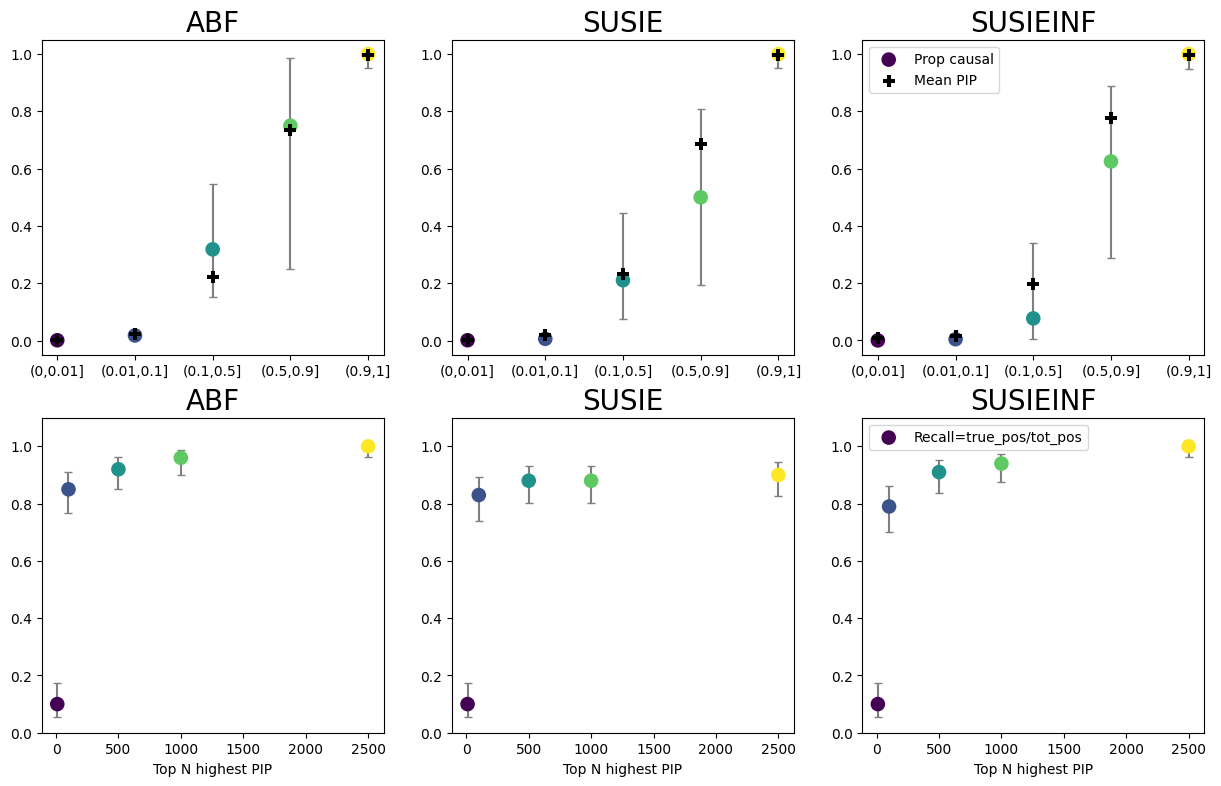

In [19]:
fig,ax = plt.subplots(2,3, figsize=(15,9))
colors = plt.cm.viridis(np.linspace(0, 1, len(bins)-1))
for i,method in enumerate(methods):
    df = calib_dict[method]
    yerr = pd.concat([df['prop_causal']-df['lower'], df['upper']-df['prop_causal']], axis=1).values.T
    ax[0][i].errorbar(df['prob_group'], df['prop_causal'], 
                   yerr=yerr, 
                   fmt='o', capsize=3, color='grey', zorder=1)
    ax[0][i].scatter(df['prob_group'], df['prop_causal'], color = colors, s=90, zorder=2, label='Prop causal')
    ax[0][i].scatter(df['prob_group'], df['mean_pip'], color = 'black', s=80, linewidth=0.01, 
                  marker = 'P', zorder=3, label='Mean PIP')
    ax[0][i].set_title(method.upper(), fontsize=20)
ax[0][2].legend()
for i,method in enumerate(methods):
    df = recall_dict[method]
    yerr = pd.concat([df['recall']-df['lower'], df['upper']-df['recall']], axis=1).values.T
    ax[1][i].errorbar(df['top_n'], df['recall'], 
                   yerr=yerr, 
                   fmt='o', capsize=3, color='grey', zorder=1)
    ax[1][i].scatter(df['top_n'], df['recall'], color = colors, s=90, zorder=2, label='Recall=true_pos/tot_pos')
    ax[1][i].set_title(method.upper(), fontsize=20)
    ax[1][i].set_ylim(0, 1.1)
    ax[1][i].set_xlabel('Top N highest PIP')
ax[1][2].legend()
plt.show()

### Version 2 -- thresholding

In [20]:
methods = ['abf','susie'] +['susieinf']
sequence = np.arange(0.01, 1.01, 0.01)
calib_dict = dict()
# get calibration for all three methods
for method in methods:
    calib_df = pd.DataFrame(columns = ['threshold', 'mean_pip', 'num_causal', 'tot_v', 'prop_causal'])
    calib_df['threshold'] = sequence
    pips = all_sims[f"{method}_prob"].values[:, None]
    masks = pips > sequence
    filtered_dfs = [all_sims[mask] for mask in masks.T]
    calib_df[['mean_pip','num_causal','tot_v']] = [[df[f"{method}_prob"].mean(), len(df[df['causal_config']!=0]), len(df)] for df in filtered_dfs]
    calib_df['prop_causal'] = calib_df['num_causal'] / calib_df['tot_v']
    calib_df['calib'] = calib_df['mean_pip'] - calib_df['prop_causal']
    one_sd = [np.sqrt(a[0]*a[1]*(1-a[1]))/a[0] for a in calib_df[['tot_v','prop_causal']].values]
    calib_df['lower'] = one_sd
    calib_df['upper'] = one_sd
    calib_dict[method] = calib_df

# get recall for all three methods
tot_causal = all_sims[all_sims['causal_config']!=0].shape[0]
recall_dict = dict()
for method in methods:
    recall_df = pd.DataFrame(columns=['threshold', 'num_causal', 'tot_causal', 'recall'])
    recall_df['threshold'] = sequence
    pips = all_sims[f"{method}_prob"].values[:, None]
    masks = pips > sequence
    filtered_dfs = [all_sims[mask] for mask in masks.T]
    recall_df[['tot_causal','num_causal']] = [[tot_causal, len(df[df['causal_config']!=0])] for df in filtered_dfs]
    recall_df['recall'] = recall_df['num_causal']/recall_df['tot_causal']
    one_sd = [np.sqrt(a[0]*a[1]*(1-a[1]))/a[0] for a in recall_df[['tot_causal','recall']].values]
    recall_df['lower'] = one_sd
    recall_df['upper'] = one_sd
    recall_dict[method] = recall_df

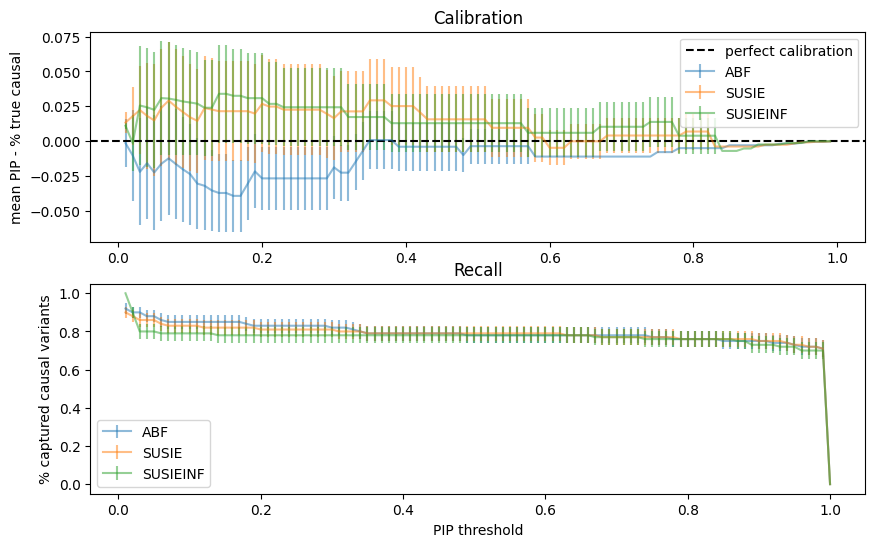

In [21]:
fig, ax = plt.subplots(2, 1, figsize = (10, 6))
for i,method in enumerate(methods):
    calib_df = calib_dict[method]
    recall_df = recall_dict[method]
    ax[0].errorbar(calib_df['threshold'], calib_df['calib'], yerr = calib_df[['lower','upper']].values.T, 
                   label=method.upper(), alpha=0.5)
    ax[1].errorbar(recall_df['threshold'], recall_df['recall'], yerr = recall_df[['lower','upper']].values.T,
                   label=method.upper(), alpha=0.5)
ax[0].axhline(y=0, color='black', linestyle='--', label = 'perfect calibration')
ax[0].set_ylabel('mean PIP - % true causal')
ax[0].set_title('Calibration')
ax[0].legend()
ax[1].set_xlabel('PIP threshold')
ax[1].set_ylabel('% captured causal variants')
ax[1].set_title('Recall')
ax[1].legend()
plt.show()

### Version 3 -- precision recall curve

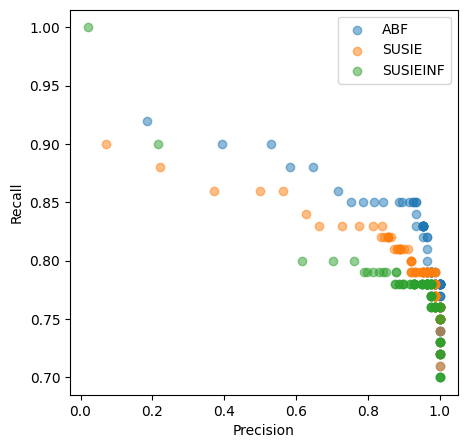

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
for method in methods:
    calib_df = calib_dict[method]
    recall_df = recall_dict[method]
    plt.scatter(calib_df['prop_causal'], recall_df['recall'], alpha=0.5, label=method.upper())
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
plt.show()

<span style="color:red"> TODO #5</span>: Change the L value 3, and h2g to 0.5. Keep the LD as 0.3. Observe the calibration and recall of ABF, SuSiE and SuSiE-inf.\
<span style="color:red"> TODO #6</span>: Change the sim_inf and fit_inf to True, keep L=3, h2g=0.5 and LD=0.3. Observe the calibration and recall of ABF, SuSiE and SuSiE-inf.\
<span style="color:red"> TODO #7</span>: Change the SuSiE and SuSiE-inf fit to use LD instead of in_sample_LD. Observe the calibration and recall of ABF, SuSiE and SuSiE-inf.